<a href="https://colab.research.google.com/github/nishamuktewar/test/blob/master/snorkel_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 install -r requirements.txt

In [0]:
!pip3 install git+https://github.com/HazyResearch/snorkel

  Cloning https://github.com/HazyResearch/snorkel to /tmp/pip-req-build-r44d913h
  Running command git clone -q https://github.com/HazyResearch/snorkel /tmp/pip-req-build-r44d913h
  Stored in directory: /tmp/pip-ephem-wheel-cache-rd4f6r3d/wheels/62/6f/22/444271063e7be3c3547fd48ba1782c8053489be0e0226990b0
Successfully built snorkel


In [0]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import sklearn
import os

In [0]:
!pip3 install treedlib

In [0]:
!pip3 install numbskull

In [0]:
from sklearn.model_selection import train_test_split
from collections import Counter
from snorkel import SnorkelSession
from snorkel.models import candidate_subclass, Context, Candidate, StableLabel
from snorkel.contrib.models.text import RawText
from snorkel.annotations import LabelAnnotator
from snorkel.learning import GenerativeModel
from snorkel.annotations import save_marginals
from snorkel.learning.tensorflow import TextRNN

W0626 22:13:25.730591 139903628289920 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
data_dir = "./data"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    !curl https://data.consumerfinance.gov/api/views/s6ew-h6mp/rows.csv?accessType=DOWNLOAD > ./data/complaints.csv

In [0]:
complaints = pd.read_csv(os.path.join(data_dir,'complaints.csv'))
complaints.info()
complaints.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1317605 entries, 0 to 1317604
Data columns (total 18 columns):
Date received                   1317605 non-null object
Product                         1317605 non-null object
Sub-product                     1082439 non-null object
Issue                           1317605 non-null object
Sub-issue                       782150 non-null object
Consumer complaint narrative    391144 non-null object
Company public response         467549 non-null object
Company                         1317605 non-null object
State                           1296981 non-null object
ZIP code                        1197445 non-null object
Tags                            180333 non-null object
Consumer consent provided?      712848 non-null object
Submitted via                   1317605 non-null object
Date sent to company            1317605 non-null object
Company response to consumer    1317598 non-null object
Timely response?                1317605 non-null obj

(1317605, 18)

In [0]:
products_w_narrative = complaints[complaints['Product'].notnull() & 
                                  complaints['Consumer complaint narrative'].notnull()]

In [0]:
print(products_w_narrative['Product'].unique())
print(products_w_narrative['Product'].value_counts())

['Debt collection'
 'Credit reporting, credit repair services, or other personal consumer reports'
 'Credit card or prepaid card' 'Checking or savings account'
 'Payday loan, title loan, or personal loan' 'Mortgage' 'Student loan'
 'Money transfer, virtual currency, or money service'
 'Vehicle loan or lease' 'Credit card' 'Credit reporting'
 'Bank account or service' 'Consumer Loan' 'Money transfers'
 'Prepaid card' 'Payday loan' 'Other financial service' 'Virtual currency']
Credit reporting, credit repair services, or other personal consumer reports    95715
Debt collection                                                                 88203
Mortgage                                                                        53631
Credit reporting                                                                31588
Credit card or prepaid card                                                     22165
Student loan                                                                    22148
Cred

In [0]:
# credit reporting only
credit_reporting = products_w_narrative[products_w_narrative['Product'] == 'Credit reporting, ' + 
                                 'credit repair services, or other personal consumer reports']
# mortgage only
mortgage = products_w_narrative[products_w_narrative['Product'] == 'Mortgage']

In [0]:
credit_narrative = credit_reporting['Consumer complaint narrative'].values
positive_labels = pd.Series(np.ones(credit_narrative.shape[0]))
positive_df = pd.DataFrame({'complaint': credit_narrative, 'label': positive_labels})

In [0]:
mortgage_narrative = mortgage['Consumer complaint narrative'].values
negative_labels = pd.Series(np.full(mortgage_narrative.shape[0], -1))
negative_df = pd.DataFrame({'complaint': mortgage_narrative, 'label': negative_labels})

In [0]:
complaints_df = pd.concat([positive_df, negative_df], ignore_index=True)
complaints_df.shape

(149346, 2)

In [0]:
complaints_df['label'].value_counts()

 1.0    95715
-1.0    53631
Name: label, dtype: int64

In [0]:
train, testval = train_test_split(complaints_df, test_size=0.2, random_state=123)
dev, test = train_test_split(testval, test_size=0.5, random_state=123)

In [0]:
POSITIVE_WORDS = r'\bcredit\b|\breport|\baddress\b|\bcreditor\b|\bexperian\b|\btransunion\b|\bequifax\b|\bfcra\b|\bcollector\b|\bdebt\b|\bconsumer\b'              
POSITIVE_PHRASE = r"\bcredit (report|agency|reporting|bureau|agencies)"
NEGATIVE_WORDS = r'\bloan\b|\bmortgage\b|\bhouse\b|\bhome\b|\bprepayment\b|\bappraise|\bforeclos\btax'
POSITIVE_ACTIONS = r'\bremov|\bdispute\b'
NEGATIVE_ACTIONS = r'\bpredator|\bmodifi\brefinanc'

FRAUD = r'\bfraudulent (account|charges)'
MONEYXFER = r'\bmoney transfer'
CREDIT_REPORTING = r'\b(identity has been compromise(|d)|data breaches|inquiries to businesses|mistakes appear in my report|reporting incorrectly|dispute(|d)|(t|T)ransunion|derogatory|experian|identity theft)'
CREDIT_REPAIR = r'\b(credit repair|hard inquiry|inquiries to businesses|mistakes appear in my report|reporting incorrectly)'


In [0]:
def lf_credit(complaint):
    if re.search(POSITIVE_WORDS, str(complaint), re.IGNORECASE):
        return 1
    else:
        return 0

def lf_credit_phrase(complaint):
    if re.search(POSITIVE_PHRASE, str(complaint), re.IGNORECASE):
        return 1
    else:
        return 0

def lf_credit_actions(complaint):
    if re.search(POSITIVE_ACTIONS, str(complaint), re.IGNORECASE):
        return 1
    else:
        return 0

def lf_mortgage(complaint):
    if re.search(NEGATIVE_WORDS, str(complaint), re.IGNORECASE):
        return -1
    else:
        return 0

def lf_mortgage_actions(complaint):
    if re.search(NEGATIVE_ACTIONS, str(complaint), re.IGNORECASE):
        return -1
    else:
        return 0
    
def lf_fraud(complaint):
    if (re.search(FRAUD, str(complaint), re.IGNORECASE)
        and not re.search(MONEYXFER, str(complaint), re.IGNORECASE)):
        return 1
    elif (re.search(FRAUD, str(complaint), re.IGNORECASE) 
          and re.search(MONEYXFER, str(complaint), re.IGNORECASE)):
        return -1
    else:
        return 0
    
def lf_reporting(complaint):
    if (re.search(CREDIT_REPORTING, str(complaint), re.IGNORECASE) 
        and not re.search(MONEYXFER, str(complaint), re.IGNORECASE)):
        return 1
    elif (re.search(CREDIT_REPORTING, str(complaint), re.IGNORECASE) 
           and re.search(MONEYXFER, str(complaint), re.IGNORECASE)):
        return -1
    else:
        return 0
    
def lf_repair(complaint):
    if (re.search(CREDIT_REPAIR, str(complaint), re.IGNORECASE) 
        and not re.search(MONEYXFER, str(complaint), re.IGNORECASE) 
        and not re.search(CREDIT_REPORTING, str(complaint), re.IGNORECASE)
       ):
        return 1
    elif ((re.search(CREDIT_REPAIR, str(complaint), re.IGNORECASE) 
           and re.search(MONEYXFER, str(complaint), re.IGNORECASE)) 
          or 
          (re.search(CREDIT_REPAIR, str(complaint), re.IGNORECASE) 
           and re.search(CREDIT_REPORTING, str(complaint), re.IGNORECASE))
         ):
        return -1
    else:
        return 0

In [0]:
session = SnorkelSession()

values = list(complaints_df.label.unique())
print(values)

# snorkel candidate, value if none defaults to binary (true, false)
Narrative = candidate_subclass('Narrative', ['narrative'], values=values)

# Make sure DB is cleared
session.query(Context).delete()
session.query(Candidate).delete()
session.query(StableLabel).delete()

[1.0, -1.0]


0

In [0]:
train_index = train.index
train.index.str = np.asarray(str(x) for x in train.index)
train_complaints = train.values[:, 0]
train_labels = train.values[:, 1]

for element in zip(train_index, train_complaints, train_labels):
    split = 0
    raw_text = RawText(stable_id=element[0], name=element[0], text=str(element[1]))
    narrative = Narrative(narrative=raw_text, split=split)
    session.add(narrative)
    context_stable_id = "~~".join([str(element[0]), str(element[0])])
    session.add(StableLabel(context_stable_ids=context_stable_id, 
                            annotator_name='gold',
                            split=0,
                            value=element[2]))
dev_index = dev.index
dev.index.str = np.asarray(str(x) for x in dev.index)
dev_complaints = dev.values[:, 0]
dev_labels = dev.values[:, 1]

for element in zip(dev_index, dev_complaints, dev_labels):
    split = 1
    raw_text = RawText(stable_id=element[0], name=element[0], text=str(element[1]))
    narrative = Narrative(narrative=raw_text, split=split)
    session.add(narrative)
    context_stable_id = "~~".join([str(element[0]), str(element[0])])
    session.add(StableLabel(context_stable_ids=context_stable_id, 
                            annotator_name='gold',
                            split=1,
                            value=element[2]))

test_index = test.index
test.index.str = np.asarray(str(x) for x in test.index)
test_complaints = test.values[:, 0]
test_labels = test.values[:, 1]

for element in zip(test_index, test_complaints, test_labels):
    split = 2
    raw_text = RawText(stable_id=element[0], name=element[0], text=str(element[1]))
    narrative = Narrative(narrative=raw_text, split=split)
    session.add(narrative)
    context_stable_id = "~~".join([str(element[0]), str(element[0])])
    session.add(StableLabel(context_stable_ids=context_stable_id, 
                            annotator_name='gold',
                            split=2,
                            value=element[2]))

session.commit()

# number of datapoints
print(session.query(Narrative).count())
# load ground truth labels
train_cand_labels = train_labels
dev_cand_labels = dev_labels
test_cand_labels = test_labels

149346


In [0]:
# test one labeling function
labeled = []
for c in session.query(Narrative).filter(Narrative.split == 1).all():
    if lf_credit(c) != 0:
        labeled.append(c)
print("Number labeled:", len(labeled))

Number labeled: 11252


In [0]:
LFs = [lf_credit, lf_credit_phrase, lf_credit_actions, lf_mortgage, lf_mortgage_actions, lf_fraud, lf_reporting, lf_repair]
# apply labeling functions
labeler = LabelAnnotator(lfs = LFs)
L_train = labeler.apply(split=0)

  0%|          | 24/119476 [00:00<08:19, 239.04it/s]

Clearing existing...
Running UDF...


100%|██████████| 119476/119476 [08:02<00:00, 247.75it/s]


In [0]:
# see what's going on
print(L_train.get_candidate(session, 0))
print(L_train.get_key(session, 0))
print(L_train.lf_stats(session))


Narrative(Raw Text On XX/XX/2017, I spoke with Wells Fargo Mortgage XXXX XXXX XXXX XXXX ext. XXXX regarding my additional principal payments being intentionally delayed ( and held in " unapplied funds '' by Wells Fargo ) due to their systems limitations, despite clearly indicated markings in writing ( and online ) showing the funds are intended as Additional Principal Payments or Principal Payments. I have had multiple experiences in the past year where my additional principal payments have been wrongfully held in " unapplied '' status, despite these payments being clearly marked in writing as " Principal Payments '' or " Additional Principal Payments ''. The aggregate of these wrongful delays in applying principal payments over the length of my 30 year mortgage could result in thousands of dollars of profit to Wells Fargo in the form of accruing interest. In filing my complaint, Wells Fargo Mortgage was dismissive of my complaint, while defending their payments systems inability to ac

In [0]:
gen_model = GenerativeModel()
gen_model.train(L_train, epochs=20, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=1e-6)

Inferred cardinality: 2


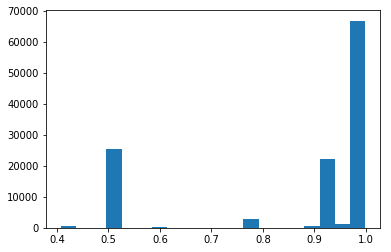

In [0]:
train_marginals = gen_model.marginals(L_train)
plt.hist(train_marginals, bins=20)
plt.show()

In [0]:
accuracy = gen_model.score(L_train, train_cand_labels)
accuracy[0]
print("precision: {:.5f}".format(accuracy[0]), "recall: {:.5f}".format(accuracy[1]), 
      "F-beta: {:.5f}".format(accuracy[2]))

precision: 0.64852 recall: 0.96839 F-beta: 0.77681


In [0]:
# Collect the majority vote answer for each complaint
mv = []
for i in range(L_train.shape[0]):
    if np.diff(L_train[i].indptr) != 0:   #indicates that there is no coverage for a particular datapoint
        c = Counter([L_train[i,j] for j in L_train[i].nonzero()[1]])
        #print(c)
        mv.append(c.most_common(1)[0][0])
        #print(c.most_common(1)[0][0])
    else:
        mv.append(-1) # assume that no label is equivalent to a negative example

mv = np.array(mv)

# Count the number correct by majority vote
n_correct = np.sum([1 for i in range(L_train.shape[0]) if mv[i] == train_cand_labels[i]])
print ("Accuracy:{}".format(n_correct / float(L_train.shape[0])))
print ("Number incorrect:{}".format(L_train.shape[0] - n_correct))

# Compute and return precision, recall, and F1 score
tp = (0.5 * (mv * train_cand_labels + 1))[mv == 1].sum()
pred_pos = mv[mv == 1].sum()
p = tp / float(pred_pos) if pred_pos > 0 else 0.0
pos = train_cand_labels[train_cand_labels == 1].sum()
r = tp / float(pos) if pos > 0 else 0.0

# Compute general F-beta score
beta=1
if p + r > 0:
    f_beta = (1 + beta**2) * ((p * r) / (((beta**2) * p) + r))
else:
    f_beta = 0.0
p, r, f_beta
print("precision: {:.5f}".format(p), "recall: {:.5f}".format(r), "F-beta: {:.5f}".format(f_beta))


Accuracy:0.8144564598747865
Number incorrect:22168
precision: 0.79259 recall: 0.96212 F-beta: 0.86916


In [0]:
L_dev = labeler.apply(split=1)
# score it
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, dev_cand_labels)

Clearing existing...


  0%|          | 26/14935 [00:00<00:58, 256.27it/s]

Running UDF...


100%|██████████| 14935/14935 [00:59<00:00, 251.10it/s]


Scores (Un-adjusted)
Pos. class accuracy: 0.971
Neg. class accuracy: 0.0662
Precision            0.646
Recall               0.971
F1                   0.776
----------------------------------------
TP: 9236 | FP: 5060 | TN: 359 | FN: 280



In [0]:
save_marginals(session, L_train, train_marginals)

Saved 119476 marginals


In [0]:
train_cands = session.query(Narrative).filter(Narrative.split == 0).order_by(Narrative.id).all()
dev_cands   = session.query(Narrative).filter(Narrative.split == 1).order_by(Narrative.id).all()
test_cands  = session.query(Narrative).filter(Narrative.split == 2).order_by(Narrative.id).all()


In [0]:
train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   10,
    'dropout':    0.2,
    'print_freq': 5,
    'seed': 123,
    'batch_size': 10
}

lstm = TextRNN(seed=123, cardinality=Narrative.cardinality)
# Note: Y_train are the marginals but Y_dev are the gold/ ground truth labels
lstm.train(X_train=train_cands, Y_train=train_marginals, X_dev=dev_cands, Y_dev=dev_cand_labels, **train_kwargs)

In [0]:
accuracy_dev = lstm.score(dev_cands, dev_cand_labels)
print("precision: {:.5f}".format(accuracy_dev[0]), "recall: {:.5f}".format(accuracy_dev[1]), 
      "F-beta: {:.5f}".format(accuracy_dev[2]))

In [0]:
accuracy_test = lstm.score(test_cands, test_cand_labels)
print("precision: {:.5f}".format(accuracy_test[0]), "recall: {:.5f}".format(accuracy_test[1]), 
      "F-beta: {:.5f}".format(accuracy_test[2]))